In [18]:
#Cada columna representa un regundo de actividad del paciente.
#Cada fila representa un paciente diferente.
#La columna y es la categoria a la cual pertenece el paciente
#    5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open 
#    4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed 
#    3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area 
#    2 - They recorder the EEG from the area where the tumor was located 
#    1 - Recording of seizure activity 
#De la categoria de 2-5 son pacientes que no sufren de epilepsia, y la 1 si. 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import itertools

/opt/miniconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .linbin import fast_linbin
/opt/miniconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:26: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from .linbin import fast_linbin
/opt/miniconda/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._smoothers_lowess import lowess as _lowess
/opt/miniconda/lib/python2.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:11: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from ._smoothers_lowess import lowess as _lowess


In [20]:
data = pd.read_csv("Data/data.csv")
del data["Unnamed: 0"]#borrando primera columna, correspondiente a la identificacion del paciente

In [21]:
np.sum(np.sum(data.isna())) # checking for nan values

0

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [28]:
def logisticRegression(X, y):
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = LogisticRegression(solver='lbfgs', multi_class='ovr')
    clf.fit(Xtr, ytr)
    acc = clf.score(Xts, yts)
    predicts = clf.predict(Xts)
    print "Logistic regression reports:\n", classification_report(yts, predicts)
    print "Logistic regression accuracy:", acc
    return confusion_matrix(yts, predicts)

In [24]:
def svm(X, y):
    print "calculating..."
    Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)
    clf = SVC(kernel="poly", degree=2)
    clf.fit(Xtr, ytr)
    acc = clf.score(Xts, yts)
    predicts = clf.predict(Xts)
    print "SVM reports:\n", classification_report(yts, predicts)
    print "SVM accuracy:", acc

Logistic regression reports:
             precision    recall  f1-score   support

          1       0.75      0.32      0.45       678
          2       0.11      0.02      0.04       696
          3       0.08      0.01      0.02       699
          4       0.20      0.21      0.20       663
          5       0.28      0.87      0.43       714

avg / total       0.28      0.29      0.23      3450

Logistic regression accuracy: 0.29130434782608694


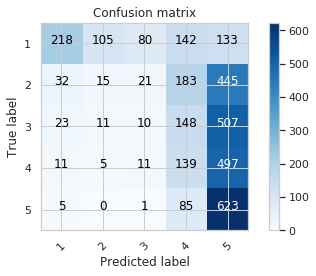

In [30]:
X = data
y = data["y"]
conf_matrix = logisticRegression(X, y)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=['1', '2', '3', '4', '5'], title='Confusion matrix')
plt.show()

In [26]:
svm(X, y)

calculating...
SVM reports:
             precision    recall  f1-score   support

          1       0.92      0.90      0.91       683
          2       0.49      0.56      0.52       717
          3       0.51      0.50      0.51       701
          4       0.71      0.72      0.71       673
          5       0.63      0.54      0.58       676

avg / total       0.65      0.64      0.64      3450

SVM accuracy: 0.6428985507246376
